Atalov S.

# Lab 2. Simpsons

---

<img src="https://upload.wikimedia.org/wikipedia/en/c/ca/Simpsons_cast.png">

In [1]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

<ipython-input-1-208e511ee693>:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


1. Датасет - скачайте и распакуйте датасет
2. Модель - используйте ResNet50 для трансфер лернинга
3. Графики - сделайте анализ лоссов и точности
4. Тест - сделайте предсказание тестовых данных
5. CSV - сохраните результаты предсказаной в `csv`-файл и сдайте вместе с ноутбуком

## Датасет

```python
link = 'https://drive.google.com/uc?export=download&id=1yRuW44NkMtxDa8Szck2DYEgJblPm_n-4'

# Создайте папку dataset командой
! mkdir dataset

# Распакуйте zip file в папку dataset командой
! unzip -q springfield.zip -d dataset

# Чтобы получить такую структуру
# /dataset/train/simpsons_dataset
```

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import zipfile
zip_path = "/content/drive/MyDrive/Colab Notebooks/springfield.zip"
extract_to = "/content/dataset"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [6]:
! mkdir dataset

mkdir: cannot create directory ‘dataset’: File exists


In [7]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# папка с данными. Если запускаете в колабе, нужно скопировать данные к себе в директорию и примонтировать диск. Если запускаете локально -- просто скачайте данные
data_dir = './dataset/train/simpsons_dataset'



# create the ImageFolder dataset
train_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['val'])

# split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% of the dataset will be used for training
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


In [8]:
dataset = datasets.ImageFolder(root=data_dir, transform=None)
class_names = dataset.classes

In [9]:
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


## Пример изображений

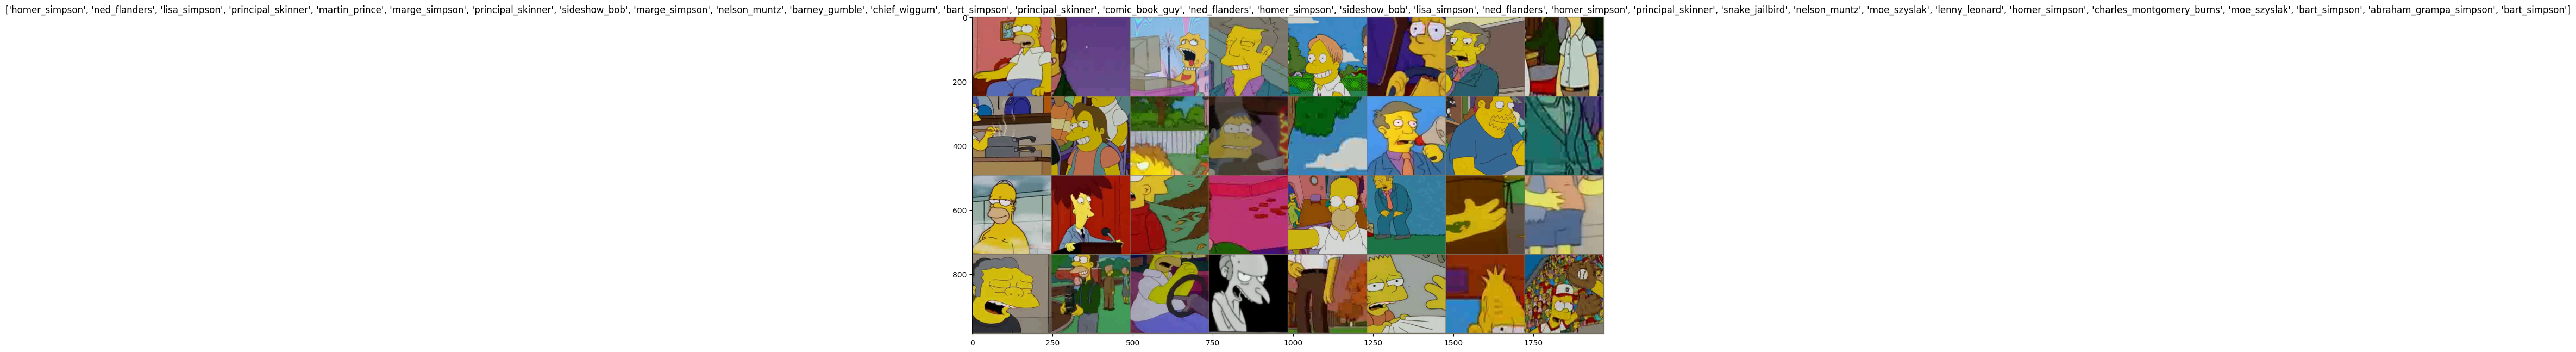

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(train_loader))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## ResNet50

Сделайте трансфер лернинг данной модели для текущего датасета. Используйте пример кода из классной работы.

- Необходимо прогнать 10 эпох
- Покажите лоссы на трейне и валидации
- Покажите точность вашей модели на трейне и валидации

### Используйте GPU (Google Colab)

In [11]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models
import torch

In [12]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


In [13]:
from pathlib import Path
TRAIN_DIR = Path('dataset/train/simpsons_dataset')
TEST_DIR = Path('dataset/testset/testset')
# Поиск всех файлов 
# rglob('*.jpg') — ищет рекурсивно все .jpg файлы (в том числе в подпапках)
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [14]:
from sklearn.model_selection import train_test_split
# список всех .jpg файлов из обучающей папки
train_val_labels = [path.parent.name for path in train_val_files]
# 25% файлов пойдут в валидацию, 75% — в обучение
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels) # разбиение будет пропорционально классам

In [15]:
n_classes = len(np.unique(train_val_labels))
print("Кол-во классов :{}".format(n_classes))

Кол-во классов :42


In [16]:
print("Размер обучающей выборки: {}".format(len(train_files)))

Размер обучающей выборки: 15699


In [17]:
model = torchvision.models.resnet50(weights="IMAGENET1K_V2")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]


In [18]:
# in_features=2048 — модель "собирает" 2048 признаков с предыдущего слоя

# out_features=1000 — выдаёт предсказания по 1000 классам (это классы ImageNet)

# bias=True — включает смещение (bias) в слое, как обычно в nn.Linear

model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [19]:
model.fc = nn.Linear(2048, n_classes)

In [20]:
DEVICE = torch.device("cuda")

In [21]:
model = model.to(DEVICE)

In [22]:
# функция обучения за одну эпоху
def fit_epoch(model, train_loader, criterion, optimizer):
    total_loss = 0.0 # сумма всех потерь
    total_correct = 0 # кол-во правильно предсказанных примеров
    total_samples = 0 # сколько данных уже прошло
    # проход по батчам
    for x, y in train_loader: # x - изображения , y - реальные классы
        x, y = x.to(DEVICE) , y.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        total_loss += loss.item() * x.size(0)
        total_correct += torch.sum(preds == y).item()
        total_samples += x.size(0)

    train_loss = total_loss / total_samples
    train_acc = total_correct / total_samples

    return train_loss, train_acc

In [23]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0           # сумма потерь
    total_correct = 0          # верные предсказания
    total_samples = 0          # всего обработано

    with torch.no_grad():      # отключение градиентов
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            loss = criterion(outputs, y)

            preds = torch.argmax(outputs, 1)
            total_loss += loss.item() * x.size(0)
            total_correct += torch.sum(preds == y).item()
            total_samples += x.size(0)

    val_loss = total_loss / total_samples
    val_acc = total_correct / total_samples
    return val_loss, val_acc


In [24]:
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)

EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    print(f"\n🟡 Epoch {epoch}/{EPOCHS}")

    model.train()
    train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
    print(f"🟢 Train | Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
    model.eval()
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)
    print(f"🔵 Val   | Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    scheduler.step()


🟡 Epoch 1/10
🟢 Train | Loss: 1.3168 | Accuracy: 0.6630
🔵 Val   | Loss: 1.4281 | Accuracy: 0.6585

🟡 Epoch 2/10
🟢 Train | Loss: 0.7733 | Accuracy: 0.7964
🔵 Val   | Loss: 0.8724 | Accuracy: 0.7779

🟡 Epoch 3/10
🟢 Train | Loss: 0.6792 | Accuracy: 0.8180
🔵 Val   | Loss: 0.8650 | Accuracy: 0.7786

🟡 Epoch 4/10
🟢 Train | Loss: 0.5829 | Accuracy: 0.8454
🔵 Val   | Loss: 0.6827 | Accuracy: 0.8297

🟡 Epoch 5/10
🟢 Train | Loss: 0.4596 | Accuracy: 0.8810
🔵 Val   | Loss: 0.4548 | Accuracy: 0.8799

🟡 Epoch 6/10
🟢 Train | Loss: 0.3966 | Accuracy: 0.8963
🔵 Val   | Loss: 0.4073 | Accuracy: 0.8882

🟡 Epoch 7/10
🟢 Train | Loss: 0.3708 | Accuracy: 0.9050
🔵 Val   | Loss: 0.4060 | Accuracy: 0.8923

🟡 Epoch 8/10
🟢 Train | Loss: 0.3480 | Accuracy: 0.9084
🔵 Val   | Loss: 0.4052 | Accuracy: 0.8992

🟡 Epoch 9/10
🟢 Train | Loss: 0.3515 | Accuracy: 0.9092
🔵 Val   | Loss: 0.3827 | Accuracy: 0.9040

🟡 Epoch 10/10
🟢 Train | Loss: 0.3342 | Accuracy: 0.9110
🔵 Val   | Loss: 0.3890 | Accuracy: 0.8992


## Делаем предсказание для тестовых изображений и сохранияем `csv` file

In [25]:

# папка с данными. Если запускаете в колабе, нужно скопировать данные к себе в директорию и примонтировать диск. Если запускаете локально -- просто скачайте данные
data_dir = './dataset/testset'

# create the ImageFolder dataset
test_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms['val'])

# create the data loaders
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [26]:
file_names = [path.split('/')[-1] for path, _ in test_dataset.imgs]

In [27]:
# Make predictions
def predict(loader, model):
    y_pred = np.array([])
    model.eval()
    with torch.no_grad():
        for x, _ in loader:
            x = x.cuda()
            scores = model(x).softmax(dim=1)
            _, predictions = scores.max(1)
            y_pred = np.append(y_pred, predictions.cpu().numpy(), axis=0)
    model.train()
    return y_pred

In [29]:
y_pred = predict(test_loader, model)
y_pred = y_pred.astype('int')

In [30]:
predictions = pd.DataFrame({
    'Id': file_names,
    'Expected': [class_names[i] for i in y_pred]
})

In [31]:
predictions = predictions.sort_values(by='Id')

In [33]:
predictions.to_csv("submission.csv", index=False)